# Handling deviation

Most wells are vertical, but many are not. All modern wells have a deviation survey, which is converted into a position log, giving the 3D position of the well in space. 

`welly` has a simple way to add a position log in a specific format, and computes a position log from it. You can use the position log to convert between MD and TVD. 

First, version check.

In [1]:
import welly
welly.__version__

'0.4.5'

## Adding deviation to an existing well

First we'll read a LAS and instantiate a well `w`

In [2]:
from welly import Well
w = Well.from_las("P-130_out.LAS")
w

Well(uwi: '100/N14A/11E05', 18 curves: ['CALI', 'DT', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'DPHI_LIM', 'DPHI_SAN', 'DPHI_DOL', 'M2R9', 'M2R6', 'M2R3', 'M2R2', 'M2R1', 'GR', 'SP', 'PEF', 'DRHO', 'RHOB'])

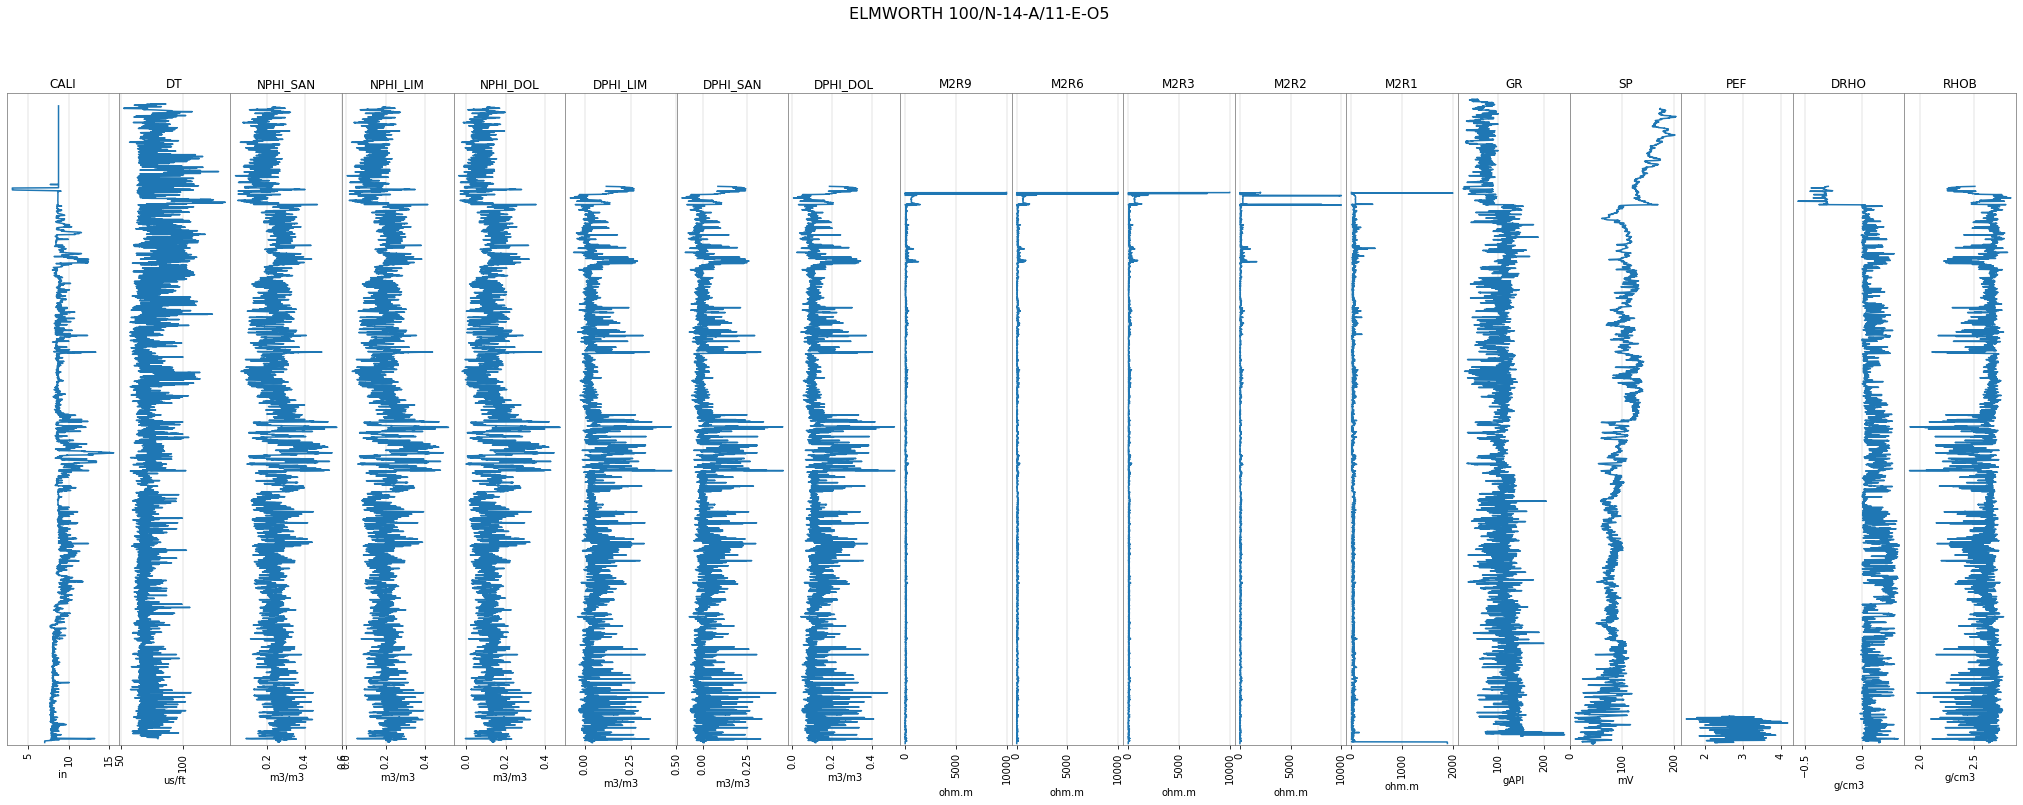

In [3]:
%matplotlib inline
w.plot()

There aren't a lot of tricks for handling the input data, which is assumed to be a CSV-like file containing columns like:

    MD, inclination, azimuth
 
For example:

In [4]:
with open('P-130_deviation_survey.csv') as f:
    lines = f.readlines()

for line in lines[:6]:
    print(line, end='')

MD,INC,AZI,TVDKB
18,0.3,0,18
38,0.5,0,38
57,1.5,0,57
84,1.8,0,84
104,0.5,0,104


Then we can turn that into an `ndarray`:

In [5]:
import numpy as np

dev = np.loadtxt('P-130_deviation_survey.csv', delimiter=',', skiprows=1, usecols=[0,1,2])
dev[:5]

array([[ 18. ,   0.3,   0. ],
       [ 38. ,   0.5,   0. ],
       [ 57. ,   1.5,   0. ],
       [ 84. ,   1.8,   0. ],
       [104. ,   0.5,   0. ]])

You can use any other method to get to an array or `pandas.DataFrame` like this one.

Then we can add the deviation survey to the well's `location` attribute. This will automatically convert it into a position log, which is an array containing the x-offset, y-offset, and TVD of the well, in that order.

In [6]:
w.location.add_deviation(dev, td=w.location.tdd)

Now you have the position log:

In [7]:
w.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.71237821e-02, 1.79999178e+01],
       [0.00000000e+00, 1.86748917e-01, 3.79994202e+01],
       [0.00000000e+00, 5.18340431e-01, 5.69962853e+01],
       [0.00000000e+00, 1.29577626e+00, 8.39850594e+01]])

Note that it is irregularly sampled &mdash; this is nothing more than the deviation survey (which is MD, INCL, AZI) converted into relative positions (i.e. deltaX, deltaY, deltaZ). These positions are relative to the tophole location. 

## MD to TVD and vice versa

We now have the methods `md2tvd` and `tvd2md` available to us:

In [8]:
w.location.md2tvd(1000)

array(998.78580297)

In [9]:
w.location.tvd2md(998.78525)

array(999.99944682)

These can also accept an array:

In [10]:
md = np.linspace(0, 300, 31)

w.location.md2tvd(md)

array([  0.        ,   9.99995431,  19.999868  ,  29.99961923,
        39.99909022,  49.99744027,  59.99503798,  69.99088025,
        79.98672251,  89.98372221,  99.98149354, 109.97926487,
       119.9770362 , 129.97480752, 139.96868036, 149.96157856,
       159.95447677, 169.94337354, 179.93182571, 189.92027789,
       199.90746639, 209.89465489, 219.88201796, 229.87007934,
       239.85814071, 249.84657206, 259.83586667, 269.82516129,
       279.8132055 , 289.7993741 , 299.7855427 ])

Note that these are linear in MD, but not in TVD.

In [11]:
w.location.md2tvd([0, 10, 20, 30])

array([ 0.        ,  9.99995431, 19.999868  , 29.99961923])

## If you have the position log, but no deviation survey

In general, deviation surveys are considered 'canonical'. That is, they are data recorded in the well. The position log &mdash; a set of (x, y, z) points in a linear Euclidean space like (X_UTM, Y_UTM, TVDSS) &mdash; is then computed from the deviation survey. 

If you have deviation *and* position log, I recommend loading the deviation survey as above.

If you *only* have position, in a 3-column array-like called `position` (say), then you can add it to the well like so:

    w.location.position = np.array(position)

You can still use the MD-to-TVD and TVD-to-MD converters above, and `w.position.trajectory()` will work as usual, but you won't have `w.position.dogleg` or `w.position.deviation`.

## Dogleg severity

The method stores the dogleg severity:

In [12]:
w.location.dogleg[:10]

array([5.23598776e-03, 3.49065850e-03, 1.74532925e-02, 5.23598776e-03,
       2.26892803e-02, 2.26892803e-02, 1.22173048e-02, 8.72664626e-03,
       3.49065850e-03, 1.00000000e-09])

## Starting from new well

Data from Rob: 

In [13]:
import pandas as pd

dev = pd.read_csv('deviation.csv')
dev.head(10)

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m]
0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17
3,134.00,0.9,15.59,133.99,1.47,0.30,0.03
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27
5,188.60,1.2,6.00,188.58,2.48,0.45,0.12
6,218.80,2.5,1.30,218.76,3.45,0.49,1.30
7,248.70,5.0,351.60,248.60,5.39,0.32,2.58
8,275.82,6.6,346.29,275.58,8.08,-0.22,1.86
9,305.09,8.2,344.29,304.60,11.72,-1.19,1.66


In [14]:
dev.tail()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m]
75,2171.08,35.90,298.69,1935.50,472.03,-748.06,0.33
76,2199.36,36.00,298.69,1958.40,480.00,-762.62,0.11
77,2228.15,35.80,298.39,1981.72,488.07,-777.45,0.28
78,2248.73,35.80,298.49,1998.43,493.79,-788.01,0.30
79,2267.00,35.43,298.39,2013.30,498.84,-797.35,0.29


First we'll create an 'empty' well.

In [18]:
x = Well(params={'header': {'name': 'foo'}})

Now add the `Location` object to the well's `location` attribute, finally calling its `add_deviation()` method on the deviation data:

In [19]:
from welly import Location

x.location = Location(params={'kb': 100})

x.location.add_deviation(dev[['MD[m]', 'Inc[deg]', 'Azi[deg]']].values)

Let's see how our new position data compares to what was in the `deviation.csv` data file:

### Compare x, y, and dogleg

In [20]:
np.set_printoptions(suppress=True)

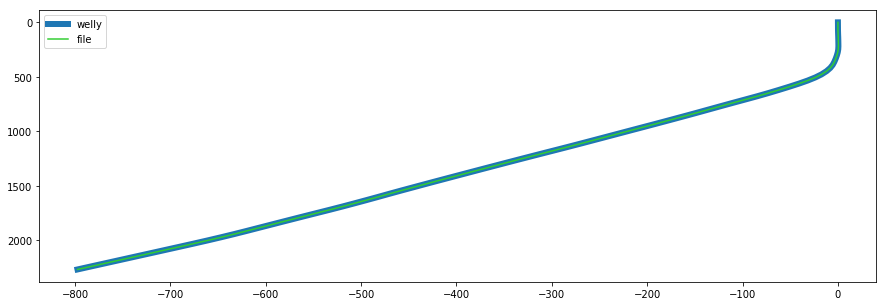

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

md_welly = x.location.deviation[:, 0]

# Plot x vs depth
ax.plot(x.location.position[:, 0], md_welly, lw=6, label="welly")
ax.plot(dev['East[m]'], dev['MD[m]'], c='limegreen', label="file")
ax.invert_yaxis()
ax.legend()

They seem to match well. There's a difference at the top because `welly` always adds a (0, 0, 0) point to both the deviation and position logs:

In [22]:
x.location.position[:7]

array([[  0.        ,   0.        ,   0.        ],
       [  0.0749919 ,   0.59445642,  76.28686274],
       [  0.16777327,   1.02376859, 104.35341738],
       [  0.29916959,   1.47035888, 133.98976125],
       [  0.3905018 ,   1.96175206, 162.71538952],
       [  0.44645432,   2.47793462, 188.5801755 ],
       [  0.49445457,   3.45095828, 218.76380232]])

In plan view, the wells match:

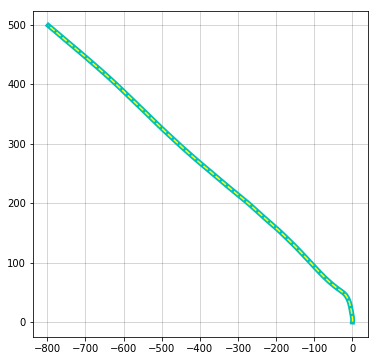

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(*x.location.position[:, :2].T, c='c', lw=5, label="welly")
ax.plot(dev['East[m]'], dev['North[m]'], c='yellow', ls='--', label="file")
#ax.set_xlim(-20, 800); ax.set_ylim(-820, 20)
ax.grid(color='black', alpha=0.2)

## Fit a spline to the position log

To make things a bit more realistic, we can shift to the correct spatial datum, i.e. the (x, y, z) of the top hole, where _z_ is the KB elevation. 

We can also adjust the _z_ value to elevation (i.e. negative downwards).

In [20]:
np.set_printoptions(suppress=True, precision=2)

x.location.trajectory(datum=[111000, 2222000, 100], elev=True)

array([[ 111000.24, 2222000.71,     100.04],
       [ 111000.21, 2222000.68,      97.76],
       [ 111000.18, 2222000.65,      95.49],
       ...,
       [ 110205.04, 2222497.75,   -1909.58],
       [ 110203.91, 2222498.41,   -1911.43],
       [ 110202.79, 2222499.07,   -1913.28]])

We can make a 3D plot with this trajectory:

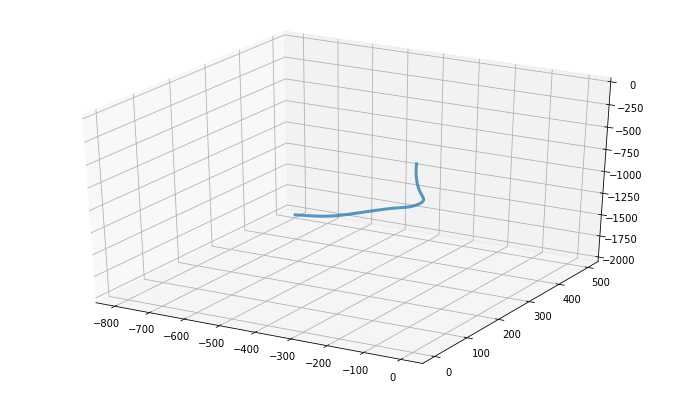

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': '3d'})
ax.plot(*x.location.trajectory().T, lw=3, alpha=0.75)
plt.show()

## Compare doglegs

The `deviation.csv` file also contains a measure of dogleg severity, which `welly` also generates (since v0.4.2). Let's make sure they agree:

Text(80, 3.5, 'welly')

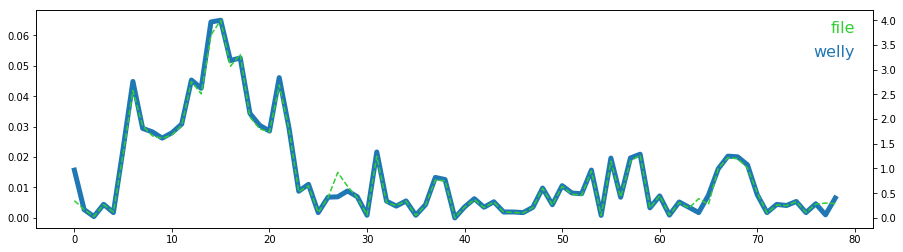

In [22]:
fig, ax = plt.subplots(figsize=(15,4))

ax.plot(x.location.dogleg, lw=5, label="welly")
ax = plt.twinx(ax=ax)
ax.plot(dev['Dogleg [deg/30m]'], c='limegreen', ls='--', label="file")
ax.text(80, 4, 'file', color='limegreen', ha='right', va='top', size=16)
ax.text(80, 3.5, 'welly', color='C0', ha='right', va='top', size=16)

They *mostly* agree. 

## Implementation details

The position log is computed from the deviation survey with the minimum curvature algorithm, which is fairly standard in the industry. To use a different method, pass `method='aa'` (average angle) or `method='bt'` (balanced tangent) directly to `Location.compute_position_log()` yourself. 

Once we have the position log, we still need a way to look up arbitrary depths. To do this, we use a cubic spline fitted to the position log. This should be OK for most 'natural' well paths, but it might break horribly. If you get weird results, you can pass `method='linear'` to the conversion functions — less accurate but more stable.

----

## Azimuth datum

You can adjust the angle of the azimuth datum with the `azimuth_datum` keyword argument. The default is zero, which means the azimuths in your survey are in degrees relative to grid north (of your UTM grid, say).

Let's make some fake data like

    MD, INCL, AZI

In [23]:
dev = [[100,  0, 0],
       [200, 10, 45],
       [300, 20, 45],
       [400, 20, 45],
       [500, 20, 60],
       [600, 20, 75],
       [700, 90, 90],
       [800, 90, 90],
       [900, 90, 90],
      ]

In [24]:
z = welly.Well(params={'name': 'foo'})
z.location = welly.Location(params={'kb': 10})
z.location.add_deviation(dev, td=1000, azimuth_datum=20)

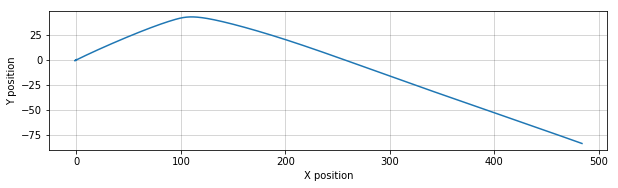

In [25]:
z.location.plot_plan()

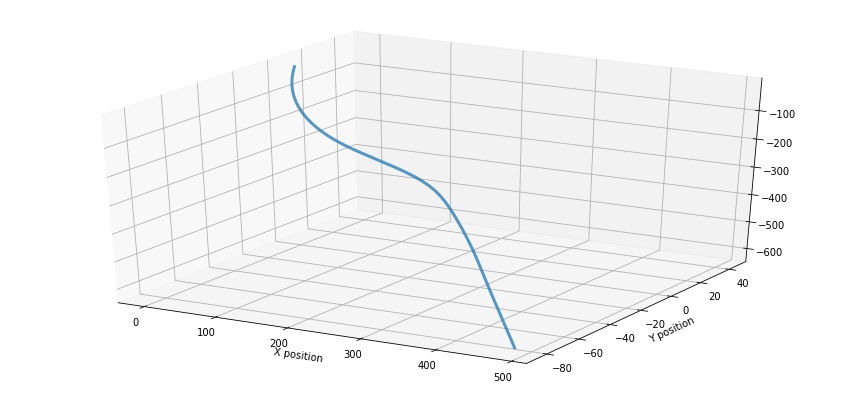

In [26]:
z.location.plot_3d()

## TODO

- Add `plot_projection()` for a vertical projection.
- Use `cartopy` for the map.
- Export a `shapely` linestring.
- Export SHP?
- Export 3D `postgis` object.

----

&copy; Agile Scientific 2019, licensed CC-BY / Apache 2.0